In [416]:
import pandas as pd
import numpy as np
import datetime
from catboost import CatBoostClassifier, Pool, cv

In [417]:
df = pd.read_csv('train.csv')

In [418]:
import seaborn as sn
import matplotlib.pyplot as plt

In [419]:
import math
def deg_to_rad(dr):
    return (dr*math.pi)/180

df['pick_lat'] = deg_to_rad(df['pick_lat'])
df['pick_lon'] = deg_to_rad(df['pick_lon'])
df['drop_lat'] = deg_to_rad(df['drop_lat'])
df['drop_lon'] = deg_to_rad(df['drop_lon'])

In [420]:
dlon = df['drop_lon'] - df['pick_lon']
dlat = df['drop_lat'] - df['pick_lat']

In [421]:
df['dist'] = np.sin(dlat/2)**2 + np.cos(df['pick_lat'])*np.cos(df['drop_lat'])*np.sin(dlon/2)**2

In [422]:
df['dist'] = 2*np.arctan2(df['dist']**0.5,(1-df['dist'])**0.5)

In [423]:
R = 6373.0
df['dist'] = R*df['dist']

In [424]:
df['fare'].count()
df['label'] = df['label'].map({'correct': 1, 'incorrect': 0})

In [425]:
#df = df.dropna(how='any')           # assign back
df.dropna(how='any', inplace=True)
#df = df.fillna(df.mode())

In [426]:
#indexNames = df[(df['fare'] <= 20) | (df['fare'] >= 500)].index
 
# Delete these row indexes from dataFrame
#df.drop(indexNames ,inplace=True)

In [427]:
df

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,dist
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,0.119774,1.394506,0.120485,1.394139,270.32,1,5.094369
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,0.120181,1.394490,0.120667,1.394384,197.85,1,3.169052
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,0.120574,1.393909,0.121068,1.394773,301.64,1,6.307375
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,0.120876,1.394335,0.120907,1.394467,82.30,1,0.862217
5,189129552,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,0.124512,1.394464,0.120753,1.393905,1065.02,1,24.214638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17171,213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,0.127247,1.407376,0.127215,1.407708,198.26,1,2.106037
17172,213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,0.120527,1.393673,0.121316,1.395197,581.23,1,10.871789
17173,213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,0.123780,1.394518,0.123942,1.394548,76.20,1,1.045847
17174,213815405,10.5,858.0,115.0,0.0000,317.0,1/31/2020 23:39,1/31/2020 23:53,0.121220,1.394113,0.121051,1.394536,133.31,1,2.879981


Text(0.5, 1.0, 'Equatorial coordinates')

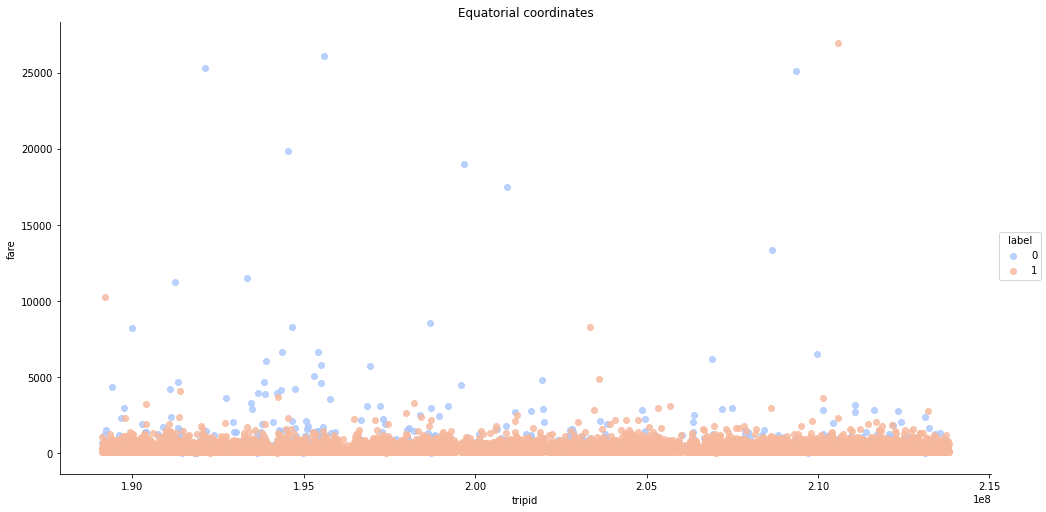

In [428]:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

sns.lmplot(x="tripid", y="fare", data=df, hue='label', fit_reg=False, palette='coolwarm', size=7, aspect=2)
plt.title('Equatorial coordinates')

In [429]:
df.describe()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,dist
count,1.696800e+04,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000,16968.000000
mean,2.014695e+08,13.721437,1702.836987,628.875000,32.045122,112.489510,0.121565,1.396229,0.121619,1.396213,312.657884,0.910066,4.856351
std,7.453627e+06,98.992493,8121.556167,8064.657846,465.564240,442.129943,0.003680,0.004238,0.006637,0.006292,606.372103,0.286096,43.287935
min,1.891236e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.103631,1.393106,0.103705,0.790769,0.000000,0.000000,0.000000
25%,1.947342e+08,10.500000,548.000000,33.000000,0.000000,26.000000,0.119814,1.394003,0.119827,1.393996,125.500000,1.000000,1.486629
50%,2.013928e+08,10.500000,1009.000000,123.000000,0.115600,73.000000,0.120672,1.394494,0.120706,1.394501,211.050000,1.000000,3.217561
75%,2.083314e+08,10.500000,1802.250000,351.000000,14.334400,144.000000,0.122918,1.395504,0.122986,1.395565,366.205000,1.000000,6.153272
max,2.138173e+08,12795.030000,453872.000000,453650.000000,26198.601400,51288.000000,0.140517,1.413884,0.840062,1.413886,26945.990000,1.000000,5611.282395


In [430]:
def dummy_df(df, todummy_list):
    
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix = x, dummy_na=False)
        df = df.drop(x,1)
        df = pd.concat((df, dummies), axis=1)
        
    return df

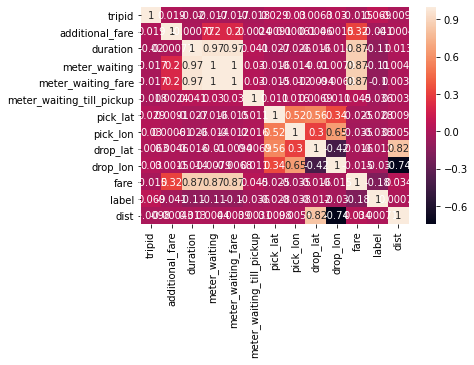

In [431]:
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [432]:
df.columns

Index(['tripid', 'additional_fare', 'duration', 'meter_waiting',
       'meter_waiting_fare', 'meter_waiting_till_pickup', 'pickup_time',
       'drop_time', 'pick_lat', 'pick_lon', 'drop_lat', 'drop_lon', 'fare',
       'label', 'dist'],
      dtype='object')

In [433]:
df = df.drop(['tripid','meter_waiting','meter_waiting_fare','pickup_time','drop_time','pick_lat','pick_lon','drop_lat','drop_lon'], axis = 1) 

In [434]:
y = df['label']
df = df.drop(['label'], axis = 1)

In [435]:
X = df

In [436]:
from sklearn.model_selection import train_test_split
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [437]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [438]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

rfc=RandomForestClassifier(random_state=42)

In [439]:
"""
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
"""

'\nCV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)\nCV_rfc.fit(X_train, y_train)\n'

In [440]:
#CV_rfc.best_params_

In [441]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 100, max_depth=8, criterion='gini')

In [442]:
rfc1.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, random_state=42)

In [443]:
pred=rfc1.predict(X_test)

In [444]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
print("Accuracy for Random Forest on CV data: ",f1_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.9697478991596639


In [445]:
X_train

,additional_fare,duration,meter_waiting_till_pickup,fare,dist
15679,5.0,204.0,0.0,69.88,0.909927
11428,60.5,6105.0,160.0,732.58,7.465595
13250,40.5,1336.0,254.0,231.76,0.002225
6925,10.5,1556.0,133.0,204.01,2.795257
2898,10.5,1471.0,105.0,285.39,3.872020
...,...,...,...,...,...
16442,10.5,1466.0,22.0,307.43,6.577651
2461,5.0,732.0,0.0,149.76,1.307300
4835,10.5,766.0,108.0,180.79,3.252829
9718,10.5,1992.0,132.0,275.10,6.299747


In [446]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [447]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
#print("F1 score = {}".format(f1_score(y_test, y_pred)))

In [448]:
#Xgboost

In [449]:
from xgboost import XGBClassifier

In [450]:
#!pip install mlxtend

In [451]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

# Classifiers
from sklearn.svm import NuSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier # <- Here is our boy

# Used to ignore warnings generated from StackingCVClassifier
import warnings
warnings.simplefilter('ignore')

In [452]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

In [453]:
"""
for key in classifiers:
    # Get classifier
    classifier = classifiers[key]
    
    # Fit classifier
    classifier.fit(X_train, y_train)
        
    # Save fitted classifier
    classifiers[key] = classifier
"""

'\nfor key in classifiers:\n    # Get classifier\n    classifier = classifiers[key]\n    \n    # Fit classifier\n    classifier.fit(X_train, y_train)\n        \n    # Save fitted classifier\n    classifiers[key] = classifier\n'

In [454]:
"""
results = pd.DataFrame()
for key in classifiers:
    # Make prediction on test set
    y_pred = classifiers[key].predict(X_test)
    
    # Save results in pandas dataframe object
    results[f"{key}"] = y_pred

# Add the test set to the results object
results["Target"] = y_test
print("F1 score = {}".format(f1_score(y_test, y_pred)))
"""

'\nresults = pd.DataFrame()\nfor key in classifiers:\n    # Make prediction on test set\n    y_pred = classifiers[key].predict(X_test)\n    \n    # Save results in pandas dataframe object\n    results[f"{key}"] = y_pred\n\n# Add the test set to the results object\nresults["Target"] = y_test\nprint("F1 score = {}".format(f1_score(y_test, y_pred)))\n'

In [455]:
#y_pred

In [456]:
df = pd.read_csv('train.csv')

In [457]:
xgb = CatBoostClassifier(n_estimators=2000)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)

print("F1 score = {}".format(f1_score(y_test, preds)))

Learning rate set to 0.015696
0:	learn: 0.6736914	total: 4.96ms	remaining: 9.91s
1:	learn: 0.6544668	total: 10ms	remaining: 10s
2:	learn: 0.6361011	total: 13.8ms	remaining: 9.21s
3:	learn: 0.6230509	total: 15.8ms	remaining: 7.88s
4:	learn: 0.6065203	total: 19.5ms	remaining: 7.76s
5:	learn: 0.5933167	total: 23ms	remaining: 7.64s
6:	learn: 0.5774585	total: 26.6ms	remaining: 7.58s
7:	learn: 0.5630455	total: 30.2ms	remaining: 7.52s
8:	learn: 0.5490887	total: 34ms	remaining: 7.52s
9:	learn: 0.5362196	total: 37.5ms	remaining: 7.47s
10:	learn: 0.5252734	total: 41.2ms	remaining: 7.44s
11:	learn: 0.5134975	total: 44.6ms	remaining: 7.38s
12:	learn: 0.5019536	total: 47.9ms	remaining: 7.32s
13:	learn: 0.4927746	total: 51.2ms	remaining: 7.26s
14:	learn: 0.4809912	total: 54.6ms	remaining: 7.22s
15:	learn: 0.4697983	total: 58ms	remaining: 7.19s
16:	learn: 0.4623610	total: 59.9ms	remaining: 6.99s
17:	learn: 0.4529976	total: 63.3ms	remaining: 6.97s
18:	learn: 0.4433346	total: 66.7ms	remaining: 6.96s
19

184:	learn: 0.1783620	total: 807ms	remaining: 7.92s
185:	learn: 0.1781880	total: 824ms	remaining: 8.03s
186:	learn: 0.1779678	total: 839ms	remaining: 8.14s
187:	learn: 0.1778551	total: 851ms	remaining: 8.2s
188:	learn: 0.1776542	total: 865ms	remaining: 8.29s
189:	learn: 0.1775471	total: 883ms	remaining: 8.41s
190:	learn: 0.1774452	total: 905ms	remaining: 8.57s
191:	learn: 0.1773186	total: 920ms	remaining: 8.66s
192:	learn: 0.1770456	total: 933ms	remaining: 8.73s
193:	learn: 0.1768520	total: 945ms	remaining: 8.8s
194:	learn: 0.1767201	total: 967ms	remaining: 8.95s
195:	learn: 0.1764639	total: 997ms	remaining: 9.18s
196:	learn: 0.1762322	total: 1.02s	remaining: 9.39s
197:	learn: 0.1760601	total: 1.05s	remaining: 9.53s
198:	learn: 0.1758321	total: 1.06s	remaining: 9.56s
199:	learn: 0.1756132	total: 1.07s	remaining: 9.6s
200:	learn: 0.1752914	total: 1.07s	remaining: 9.59s
201:	learn: 0.1752366	total: 1.07s	remaining: 9.57s
202:	learn: 0.1751096	total: 1.08s	remaining: 9.55s
203:	learn: 0.1

343:	learn: 0.1574915	total: 1.83s	remaining: 8.83s
344:	learn: 0.1573874	total: 1.84s	remaining: 8.85s
345:	learn: 0.1573291	total: 1.85s	remaining: 8.86s
346:	learn: 0.1572571	total: 1.86s	remaining: 8.85s
347:	learn: 0.1571396	total: 1.86s	remaining: 8.84s
348:	learn: 0.1570594	total: 1.87s	remaining: 8.83s
349:	learn: 0.1569312	total: 1.87s	remaining: 8.82s
350:	learn: 0.1568300	total: 1.87s	remaining: 8.81s
351:	learn: 0.1567934	total: 1.88s	remaining: 8.79s
352:	learn: 0.1567508	total: 1.88s	remaining: 8.78s
353:	learn: 0.1566689	total: 1.89s	remaining: 8.77s
354:	learn: 0.1566335	total: 1.89s	remaining: 8.77s
355:	learn: 0.1565680	total: 1.9s	remaining: 8.75s
356:	learn: 0.1564770	total: 1.9s	remaining: 8.74s
357:	learn: 0.1564251	total: 1.9s	remaining: 8.73s
358:	learn: 0.1563089	total: 1.91s	remaining: 8.72s
359:	learn: 0.1561895	total: 1.91s	remaining: 8.7s
360:	learn: 0.1559912	total: 1.91s	remaining: 8.69s
361:	learn: 0.1559357	total: 1.92s	remaining: 8.68s
362:	learn: 0.15

527:	learn: 0.1448464	total: 2.62s	remaining: 7.3s
528:	learn: 0.1447737	total: 2.63s	remaining: 7.33s
529:	learn: 0.1447419	total: 2.64s	remaining: 7.32s
530:	learn: 0.1446993	total: 2.64s	remaining: 7.32s
531:	learn: 0.1446513	total: 2.65s	remaining: 7.31s
532:	learn: 0.1445625	total: 2.65s	remaining: 7.3s
533:	learn: 0.1445301	total: 2.66s	remaining: 7.29s
534:	learn: 0.1444932	total: 2.66s	remaining: 7.29s
535:	learn: 0.1444516	total: 2.66s	remaining: 7.28s
536:	learn: 0.1444200	total: 2.67s	remaining: 7.27s
537:	learn: 0.1443742	total: 2.67s	remaining: 7.26s
538:	learn: 0.1443253	total: 2.67s	remaining: 7.25s
539:	learn: 0.1442877	total: 2.68s	remaining: 7.24s
540:	learn: 0.1442164	total: 2.68s	remaining: 7.24s
541:	learn: 0.1441541	total: 2.69s	remaining: 7.23s
542:	learn: 0.1441233	total: 2.69s	remaining: 7.22s
543:	learn: 0.1440795	total: 2.69s	remaining: 7.21s
544:	learn: 0.1440532	total: 2.7s	remaining: 7.2s
545:	learn: 0.1440137	total: 2.7s	remaining: 7.19s
546:	learn: 0.143

713:	learn: 0.1363940	total: 3.42s	remaining: 6.15s
714:	learn: 0.1363078	total: 3.43s	remaining: 6.16s
715:	learn: 0.1362831	total: 3.43s	remaining: 6.15s
716:	learn: 0.1362570	total: 3.44s	remaining: 6.15s
717:	learn: 0.1362451	total: 3.44s	remaining: 6.14s
718:	learn: 0.1362178	total: 3.44s	remaining: 6.14s
719:	learn: 0.1361826	total: 3.45s	remaining: 6.13s
720:	learn: 0.1361416	total: 3.45s	remaining: 6.12s
721:	learn: 0.1360640	total: 3.46s	remaining: 6.12s
722:	learn: 0.1360309	total: 3.46s	remaining: 6.11s
723:	learn: 0.1359939	total: 3.46s	remaining: 6.1s
724:	learn: 0.1359330	total: 3.47s	remaining: 6.1s
725:	learn: 0.1359081	total: 3.47s	remaining: 6.09s
726:	learn: 0.1358729	total: 3.47s	remaining: 6.08s
727:	learn: 0.1358299	total: 3.48s	remaining: 6.08s
728:	learn: 0.1358126	total: 3.48s	remaining: 6.07s
729:	learn: 0.1357599	total: 3.48s	remaining: 6.06s
730:	learn: 0.1357429	total: 3.49s	remaining: 6.06s
731:	learn: 0.1357165	total: 3.49s	remaining: 6.05s
732:	learn: 0.

903:	learn: 0.1286332	total: 4.21s	remaining: 5.1s
904:	learn: 0.1285956	total: 4.21s	remaining: 5.1s
905:	learn: 0.1285716	total: 4.22s	remaining: 5.09s
906:	learn: 0.1285300	total: 4.22s	remaining: 5.09s
907:	learn: 0.1285034	total: 4.23s	remaining: 5.08s
908:	learn: 0.1284585	total: 4.23s	remaining: 5.08s
909:	learn: 0.1284272	total: 4.24s	remaining: 5.07s
910:	learn: 0.1283772	total: 4.24s	remaining: 5.07s
911:	learn: 0.1283381	total: 4.24s	remaining: 5.06s
912:	learn: 0.1283090	total: 4.25s	remaining: 5.06s
913:	learn: 0.1282537	total: 4.25s	remaining: 5.05s
914:	learn: 0.1282331	total: 4.26s	remaining: 5.05s
915:	learn: 0.1282115	total: 4.26s	remaining: 5.05s
916:	learn: 0.1281519	total: 4.27s	remaining: 5.04s
917:	learn: 0.1281197	total: 4.27s	remaining: 5.04s
918:	learn: 0.1280976	total: 4.28s	remaining: 5.03s
919:	learn: 0.1280211	total: 4.28s	remaining: 5.02s
920:	learn: 0.1280003	total: 4.28s	remaining: 5.02s
921:	learn: 0.1279746	total: 4.29s	remaining: 5.01s
922:	learn: 0.

1086:	learn: 0.1228338	total: 5s	remaining: 4.2s
1087:	learn: 0.1227939	total: 5.01s	remaining: 4.2s
1088:	learn: 0.1227811	total: 5.02s	remaining: 4.2s
1089:	learn: 0.1227358	total: 5.03s	remaining: 4.2s
1090:	learn: 0.1226839	total: 5.04s	remaining: 4.2s
1091:	learn: 0.1226559	total: 5.04s	remaining: 4.19s
1092:	learn: 0.1226149	total: 5.04s	remaining: 4.19s
1093:	learn: 0.1225947	total: 5.05s	remaining: 4.18s
1094:	learn: 0.1225727	total: 5.05s	remaining: 4.17s
1095:	learn: 0.1225286	total: 5.06s	remaining: 4.17s
1096:	learn: 0.1225042	total: 5.06s	remaining: 4.17s
1097:	learn: 0.1224780	total: 5.06s	remaining: 4.16s
1098:	learn: 0.1224585	total: 5.07s	remaining: 4.15s
1099:	learn: 0.1224434	total: 5.07s	remaining: 4.15s
1100:	learn: 0.1224238	total: 5.08s	remaining: 4.14s
1101:	learn: 0.1223823	total: 5.08s	remaining: 4.14s
1102:	learn: 0.1223635	total: 5.08s	remaining: 4.13s
1103:	learn: 0.1223410	total: 5.09s	remaining: 4.13s
1104:	learn: 0.1223064	total: 5.09s	remaining: 4.12s
1

1265:	learn: 0.1180454	total: 5.79s	remaining: 3.35s
1266:	learn: 0.1180286	total: 5.8s	remaining: 3.35s
1267:	learn: 0.1180078	total: 5.81s	remaining: 3.35s
1268:	learn: 0.1179876	total: 5.81s	remaining: 3.35s
1269:	learn: 0.1179486	total: 5.82s	remaining: 3.34s
1270:	learn: 0.1179369	total: 5.82s	remaining: 3.34s
1271:	learn: 0.1179270	total: 5.83s	remaining: 3.33s
1272:	learn: 0.1179147	total: 5.83s	remaining: 3.33s
1273:	learn: 0.1178980	total: 5.83s	remaining: 3.32s
1274:	learn: 0.1178829	total: 5.84s	remaining: 3.32s
1275:	learn: 0.1178505	total: 5.84s	remaining: 3.31s
1276:	learn: 0.1178115	total: 5.84s	remaining: 3.31s
1277:	learn: 0.1178035	total: 5.85s	remaining: 3.3s
1278:	learn: 0.1177806	total: 5.85s	remaining: 3.3s
1279:	learn: 0.1177377	total: 5.86s	remaining: 3.29s
1280:	learn: 0.1177098	total: 5.86s	remaining: 3.29s
1281:	learn: 0.1176886	total: 5.86s	remaining: 3.28s
1282:	learn: 0.1176666	total: 5.87s	remaining: 3.28s
1283:	learn: 0.1176398	total: 5.87s	remaining: 3.

1448:	learn: 0.1137714	total: 6.58s	remaining: 2.5s
1449:	learn: 0.1137364	total: 6.59s	remaining: 2.5s
1450:	learn: 0.1136940	total: 6.59s	remaining: 2.49s
1451:	learn: 0.1136515	total: 6.6s	remaining: 2.49s
1452:	learn: 0.1136410	total: 6.6s	remaining: 2.48s
1453:	learn: 0.1136156	total: 6.61s	remaining: 2.48s
1454:	learn: 0.1135816	total: 6.61s	remaining: 2.48s
1455:	learn: 0.1135681	total: 6.61s	remaining: 2.47s
1456:	learn: 0.1135465	total: 6.62s	remaining: 2.46s
1457:	learn: 0.1134928	total: 6.62s	remaining: 2.46s
1458:	learn: 0.1134756	total: 6.62s	remaining: 2.46s
1459:	learn: 0.1134579	total: 6.63s	remaining: 2.45s
1460:	learn: 0.1134248	total: 6.63s	remaining: 2.45s
1461:	learn: 0.1134014	total: 6.63s	remaining: 2.44s
1462:	learn: 0.1133856	total: 6.64s	remaining: 2.44s
1463:	learn: 0.1133634	total: 6.64s	remaining: 2.43s
1464:	learn: 0.1133462	total: 6.65s	remaining: 2.43s
1465:	learn: 0.1133287	total: 6.65s	remaining: 2.42s
1466:	learn: 0.1132946	total: 6.65s	remaining: 2.4

1635:	learn: 0.1094098	total: 7.39s	remaining: 1.64s
1636:	learn: 0.1093708	total: 7.4s	remaining: 1.64s
1637:	learn: 0.1093267	total: 7.4s	remaining: 1.64s
1638:	learn: 0.1093159	total: 7.41s	remaining: 1.63s
1639:	learn: 0.1092977	total: 7.41s	remaining: 1.63s
1640:	learn: 0.1092841	total: 7.42s	remaining: 1.62s
1641:	learn: 0.1092570	total: 7.42s	remaining: 1.62s
1642:	learn: 0.1092437	total: 7.42s	remaining: 1.61s
1643:	learn: 0.1092151	total: 7.43s	remaining: 1.61s
1644:	learn: 0.1091937	total: 7.43s	remaining: 1.6s
1645:	learn: 0.1091676	total: 7.43s	remaining: 1.6s
1646:	learn: 0.1091529	total: 7.44s	remaining: 1.59s
1647:	learn: 0.1091424	total: 7.44s	remaining: 1.59s
1648:	learn: 0.1091171	total: 7.45s	remaining: 1.59s
1649:	learn: 0.1090916	total: 7.46s	remaining: 1.58s
1650:	learn: 0.1090807	total: 7.46s	remaining: 1.58s
1651:	learn: 0.1090473	total: 7.46s	remaining: 1.57s
1652:	learn: 0.1090311	total: 7.47s	remaining: 1.57s
1653:	learn: 0.1090272	total: 7.47s	remaining: 1.5

1824:	learn: 0.1052397	total: 8.19s	remaining: 785ms
1825:	learn: 0.1052347	total: 8.2s	remaining: 781ms
1826:	learn: 0.1052109	total: 8.21s	remaining: 777ms
1827:	learn: 0.1052064	total: 8.21s	remaining: 773ms
1828:	learn: 0.1051874	total: 8.22s	remaining: 768ms
1829:	learn: 0.1051663	total: 8.23s	remaining: 764ms
1830:	learn: 0.1051390	total: 8.23s	remaining: 760ms
1831:	learn: 0.1051202	total: 8.23s	remaining: 755ms
1832:	learn: 0.1050976	total: 8.24s	remaining: 751ms
1833:	learn: 0.1050788	total: 8.24s	remaining: 746ms
1834:	learn: 0.1050661	total: 8.24s	remaining: 741ms
1835:	learn: 0.1050398	total: 8.25s	remaining: 737ms
1836:	learn: 0.1050167	total: 8.25s	remaining: 732ms
1837:	learn: 0.1050050	total: 8.26s	remaining: 728ms
1838:	learn: 0.1049946	total: 8.26s	remaining: 723ms
1839:	learn: 0.1049874	total: 8.26s	remaining: 719ms
1840:	learn: 0.1049566	total: 8.27s	remaining: 714ms
1841:	learn: 0.1049325	total: 8.27s	remaining: 710ms
1842:	learn: 0.1049282	total: 8.28s	remaining: 

F1 score = 0.9736033075373688


In [458]:
print("Test F1 Micro Average: ", f1_score(y_test, preds))

Test F1 Micro Average:  0.9736033075373688


In [459]:
df_test = pd.read_csv('test.csv')

In [460]:
df_test['pick_lat'] = deg_to_rad(df_test['pick_lat'])
df_test['pick_lon'] = deg_to_rad(df_test['pick_lon'])
df_test['drop_lat'] = deg_to_rad(df_test['drop_lat'])
df_test['drop_lon'] = deg_to_rad(df_test['drop_lon'])

In [461]:
dlon = df_test['drop_lon'] - df_test['pick_lon']
dlat = df_test['drop_lat'] - df_test['pick_lat']

In [462]:
df_test['dist'] = np.sin(dlat/2)**2 + np.cos(df_test['pick_lat'])*np.cos(df_test['drop_lat'])*np.sin(dlon/2)**2

In [463]:
df_test['dist'] = 2*np.arctan2(df_test['dist']**0.5,(1-df_test['dist'])**0.5)

In [464]:
R = 6373.0
df_test['dist'] = R*df_test['dist']

In [465]:
df_test['pickup_time'] = [int(i.split()[1].split(':')[0]) for i in df_test['pickup_time']]

In [466]:
df_test =df_test.drop(['meter_waiting_till_pickup','pickup_time','drop_time','pick_lat','pick_lon','drop_lat','drop_lon'], axis = 1) 

In [467]:
df_new = df_test

In [468]:
df_test = df_test.drop(['tripid'], axis = 1) 

In [469]:
X_2 = df_test

In [470]:
y_ran_pred=xgb.predict(X_2)

In [471]:
df_new['prediction'] = y_ran_pred

In [472]:
df_new = df_new.drop(['additional_fare','duration','meter_waiting','meter_waiting_fare','fare','dist'], axis = 1) 

In [473]:
df_new.to_csv("prediction_results_ran.csv",index=False)

In [474]:
df_new

,tripid,prediction
0,213284604,0
1,213286352,0
2,213293973,0
3,213294622,0
4,213298687,0
...,...,...
8571,222856243,0
8572,222857785,0
8573,222858416,0
8574,222858691,0
